#**LEAFGUARD APPLICATION**

**OBJECT**: Using Big Data processing
and Data Science algorithms to diagnose plant diseases.

**DATASET** (images): https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset


**04 MAIN STEPS:**
1. Data Preparation
2. Model Building with Transfer Learning
3. Model Testing
4. Data Visualization


In [2]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create a model using weights from imagenet.

#### Import Libraries

In [37]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0
from keras.models import Model
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# IMG_SIZE is determined by EfficientNet model choice
# IMG_SIZE = 224
# BATCH_SIZE = 32

### **STAGE 1.** DATA PREPARATION

####1.1. Download and Prepare Dataset

In [5]:
# Downloads a dataset from Kaggle
!kaggle datasets download vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:12<00:00, 247MB/s]
100% 2.70G/2.70G [00:12<00:00, 239MB/s]


In [6]:
# Unzip the dataset
! unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [7]:
# Sets the data directory path
data_dir = '/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
classes = os.listdir(data_dir)
print(classes)

['Peach___healthy', 'Raspberry___healthy', 'Potato___healthy', 'Grape___Black_rot', 'Strawberry___healthy', 'Apple___Cedar_apple_rust', 'Pepper,_bell___Bacterial_spot', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Black_rot', 'Apple___Apple_scab', 'Tomato___Bacterial_spot', 'Cherry_(including_sour)___healthy', 'Tomato___Early_blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Pepper,_bell___healthy', 'Corn_(maize)___Common_rust_', 'Squash___Powdery_mildew', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Apple___healthy', 'Soybean___healthy', 'Tomato___healthy', 'Peach___Bacterial_spot', 'Tomato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Target_Spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Blueberry___healthy', 'Strawberry___Leaf_scorch', 'Ch

####1.2. Load dataset using Data Generator

In [8]:
# Create training and testing datasets
# Splitting the data into 80% for training and 20% for testing
ds_train = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=None
)

ds_test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=None
)

# Retrieves the number of classes and their names (categories)
class_names = ds_train.class_names
NUM_CLASSES = len(class_names)

print("Number of classes:", NUM_CLASSES)
print("Class names:", class_names)

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___

####1.3. Preprocess the Dataset

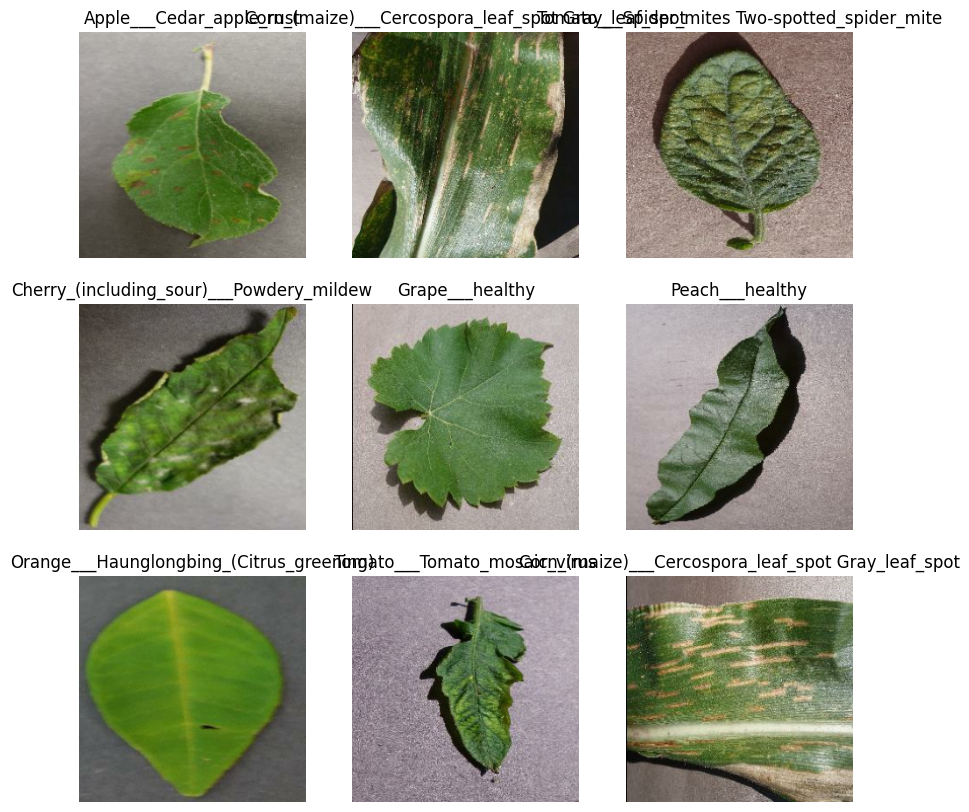

In [9]:
# Resizes images to a consistent size and defines a function to format labels for better readability
def format_label(label):
    return label_info[int(label.numpy())]

label_info = class_names

# Display few sample images with their lables (first 9 images from ds_train)
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[:,:,:].numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")
plt.show()

####1.4. Data Augmentation

In [10]:
# Define data augementation techniques (rotation, translation, flip, contrast)
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

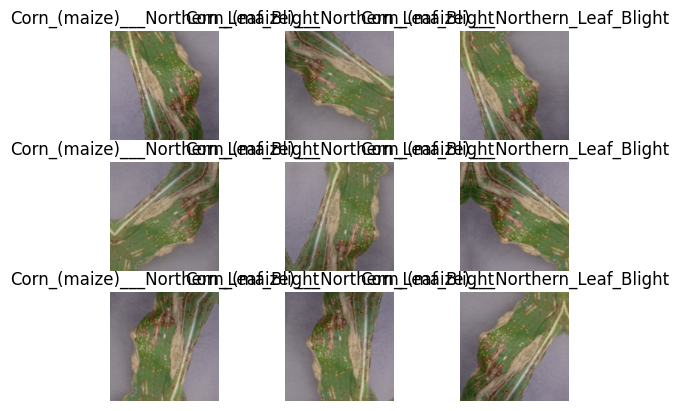

In [11]:
# Apply data augmentation to sample image to visualize the effects
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

####1.5. Further Preprocessing and Batching

In [ ]:
BATCH_SIZE = 32

# Modify image augmentation function to support single images
def img_augmentation(image):
    return image

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.cast(label, dtype=tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
    label = tf.cast(label, dtype=tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

### **STAGE 2.** MODEL BUILDING WITH TRANSFER LEARNING

####2.1. Model Configuration and Fine-tuning

In [13]:
IMG_SIZE = 224

# Configures the EfficientNetB0 model with pre-trained ImageNet weights
def configure_model():
  mymodel=EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(mymodel.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(38,activation='softmax',name='Predictions')(x)
  final_model = Model(mymodel.input, outputs=predictors)
  return final_model
final_model=configure_model()

def model(new_model=final_model,layers_num=1,trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model
final_model=model(final_model)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


####2.2. Training Setup

In [14]:
# Create Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy()) # Simplified the float conversion

# Initialize callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_plant_disease.weights.h5',
                                                monitor='val_loss', verbose=1,
                                                save_best_only=True, save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=7, min_delta=0.001)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, lr_scheduler]

# Compile the model
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

# Train the model
epochs = 100  # @param {type: "slider", min:10, max:100}

hist = final_model.fit(ds_train, epochs=epochs,
                       validation_data=ds_test,
                       callbacks=callbacks_list)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,098,249 (15.63 MB)

 Trainable params: 4,056,226 (15.47 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/100
1756/1757 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9013 - loss: 0.3595
Epoch 1: val_loss improved from inf to 0.12104, saving model to model_plant_disease.weights.h5
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 147s 42ms/step - accuracy: 0.9014 - loss: 0.3593 - val_accuracy: 0.9644 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 2/100
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9815 - loss: 0.0594
Epoch 2: val_loss improved from 0.12104 to 0.04856, saving model to model_plant_disease.weights.h5
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.9815 - loss: 0.0594 - val_accuracy: 0.9839 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 3/100
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9852 - loss: 0.0467
Epoch 3: val_loss did not improve from 0.04856
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 66s 38ms/step - accuracy: 0.9852 - loss: 0.0467 - val_accuracy: 0.9590 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 4/100
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/st

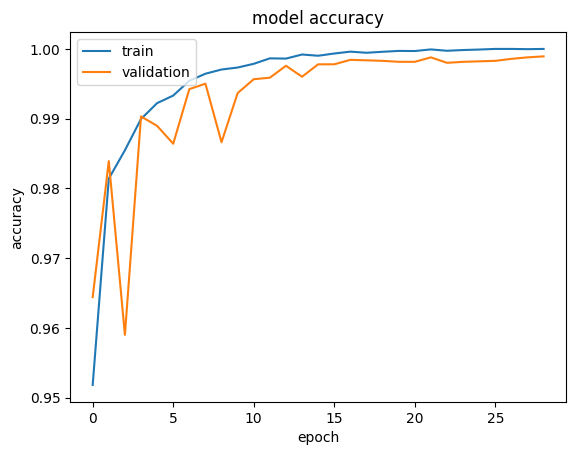

In [20]:
# History of network learning
# Plot the Graph: Accuracy Curves

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

#### 2.3. Further Model Building and Training

In [21]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

####2.4. Save the Model

In [22]:
# Create the model with the same architecture
saved_model = configure_model()

# Load the weights
saved_model.load_weights('/content/model_plant_disease.weights.h5')

# Save the model as .h5
keras.saving.save_model(saved_model,'/content/model_plant_disease.h5')

####2.5. Prediction on the test set

In [50]:
# Prediction on the test set
y_pred = []
y_true = []

for images, labels in ds_test:
    preds = final_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Select the label with the highest probability
    y_true.extend(labels.numpy())            # Store the actual labels

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

####2.6. Confusion Matrix

In [51]:
# Convert y_true from one-hot encoded to labels
y_true_labels = np.argmax(y_true, axis=1)

# Display confusion matrix
# Calculate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred)
print(cm)

[[411   0   0 ...   0   0   0]
 [  0 408   0 ...   0   0   0]
 [  0   0 353 ...   0   0   0]
 ...
 [  0   0   0 ... 362   0   0]
 [  0   0   0 ...   0 374   0]
 [  0   0   0 ...   0   0 360]]


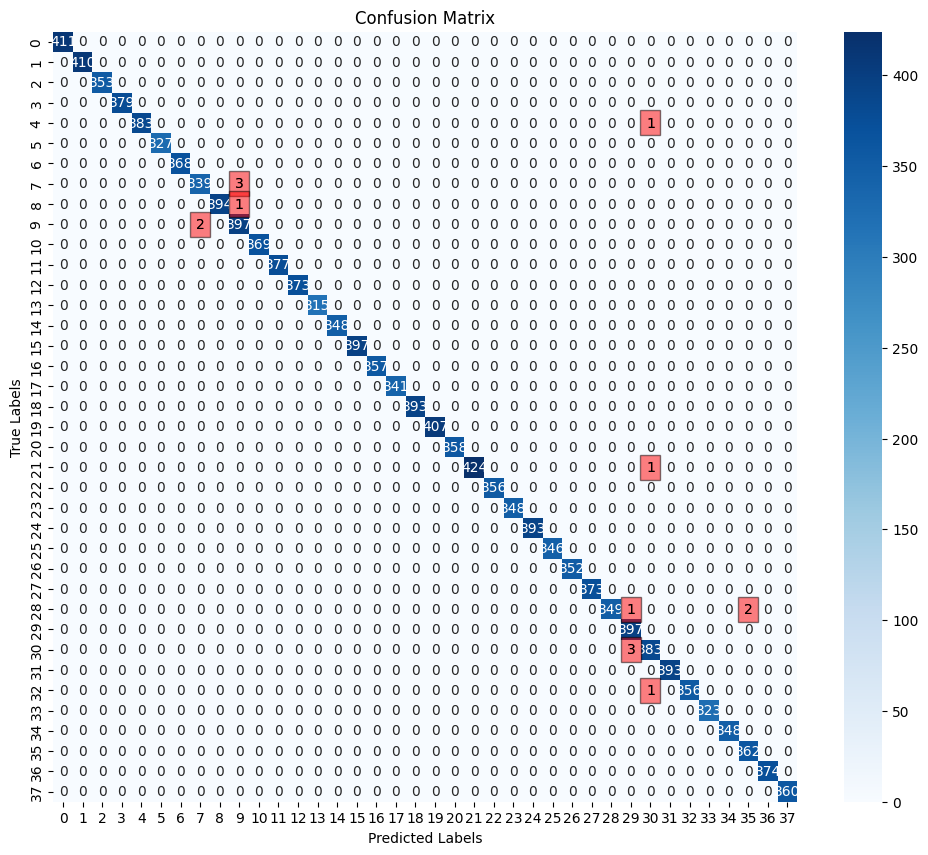

In [49]:
# Visualize confusion matrix with Seaborn
cm = np.array(cm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] != 0:
            plt.text(j+0.5, i+0.5, str(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="black",
                     bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [55]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
